Ref: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
tf.random.set_seed(42)

In [ ]:
def generate_col_to_drop(category, drop_cat_target=True):
  cat = 'ABCDE'
  cat_to_drop = list(cat.replace(category, ''))
  col = []
  if(drop_cat_target):
    col = ['Quota Premium {}'.format(c) for c in cat]
  else:
    col = ['Quota Premium {}'.format(c) for c in cat_to_drop]
  col_header = ['Quota ', 'Total Bids Received ', 'Number of Successful Bids ']
  for i in cat_to_drop:
    for j in col_header:
      col.append(j + i)
  return col

In [ ]:
base_path = '/content/gdrive/My Drive/ISY5002/'
df = pd.read_csv(base_path+'data/coe_master.csv', index_col = 0)

In [ ]:
n_steps_in, n_steps_out = 48, 48

In [ ]:
def prepare_train_val_test(df, n_steps_in, n_steps_out, category, drop_cat_target=True):
  target_col_name = 'Quota Premium {}'.format(category)
  df_drop_cat = df.drop(generate_col_to_drop(category, drop_cat_target),axis=1).to_numpy()
  rows = df_drop_cat.shape[0]
  trainX = df_drop_cat[:rows-n_steps_out*2, :]
  trainY = df[target_col_name].to_numpy()[:rows-n_steps_out*2].reshape(-1,1)
  valX = df_drop_cat[-(n_steps_out*2+n_steps_in):rows-n_steps_out, :]
  valY = df[target_col_name].to_numpy()[-(n_steps_out*2+n_steps_in):rows-n_steps_out].reshape(-1,1)
  testX = df_drop_cat[-(n_steps_in + n_steps_out):, :]
  testY = df[target_col_name].to_numpy()[-(n_steps_in + n_steps_out):].reshape(-1,1)
  actualY = df[target_col_name].to_numpy()[-n_steps_out:].reshape(-1,1)
  return trainX, trainY, valX, valY, testX, testY, actualY

In [ ]:
trainX, trainY, valX, valY, testX, testY, actualY = prepare_train_val_test(df, n_steps_in, n_steps_out, 'A')

In [ ]:
scalerX = StandardScaler().fit(trainX)
X_train_std = scalerX.transform(trainX)
X_val_std = scalerX.transform(valX)
X_test_std = scalerX.transform(testX)

scalerY = StandardScaler().fit(trainY)
y_train_std = scalerY.transform(trainY)
y_val_std = scalerY.transform(valY)
y_test_std = scalerY.transform(testY)

In [ ]:
npc = 2
pca = PCA(n_components=npc, random_state=42)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

In [ ]:
train_dataset = np.concatenate((X_train_pca, y_train_std), axis=1)
val_dataset = np.concatenate((X_val_pca, y_val_std), axis=1)
test_dataset = np.concatenate((X_test_pca, y_test_std), axis=1)

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix + 1 > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix+1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_sequences(train_dataset, n_steps_in, n_steps_out)
X_val, y_val = split_sequences(val_dataset, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test_dataset, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

n_features = X_train.shape[2]

(277, 48, 2) (277, 48)
(1, 48, 2) (1, 48)
(1, 48, 2) (1, 48)


In [ ]:
def create_lstm_model(n_steps_in, n_features, n_steps_out, model_name, units=[128], dropout=0.2, activation='tanh'):
    model = Sequential(name=model_name)
    if len(units) > 1:
      model.add(LSTM(units[0], activation=activation, return_sequences=True, input_shape=(n_steps_in, n_features)))
    else:
      model.add(LSTM(units[0], activation=activation, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(dropout))
    units.pop(0)
    for i in range(len(units)):
      return_sequence = True
      if i == len(units)-1:
        return_sequence = False  
      model.add(LSTM(units[i], activation=activation, return_sequences=return_sequence))  
      model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
def create_bidirectional_lstm_model(n_steps_in, n_features, n_steps_out, model_name, units=[128], merge_mode='concat', dropout=0.2, activation='tanh'):
    model = Sequential(name=model_name)
    model.add(Bidirectional(LSTM(units[0], activation=activation), input_shape=(n_steps_in, n_features), merge_mode=merge_mode))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
def create_callbacks(model_name):
  early_stopping = EarlyStopping(monitor="val_loss", patience = 50, restore_best_weights=True)
  model_name   = model_name  
  folder_path      = base_path + 'colab/'
  file_path        = folder_path + model_name + ".hdf5"
  checkpoint      = ModelCheckpoint(file_path, 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    mode='min')
  csv_logger      = CSVLogger(folder_path+model_name +'.csv')

  return [early_stopping, checkpoint, csv_logger]


In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def print_errors(actual, pred, model_name):
    rmse = math.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    
    print('{} RMSE: '.format(model_name), rmse)
    print('{} MAE: '.format(model_name), mae)
    print('{} MAPE: '.format(model_name), mape)

In [ ]:
def create_model_name(model, units):
  model_name = '{}{}_pc{}_lb{}'.format(model, '_'.join(str(u) for u in units), npc, n_steps_in)
  if n_features > npc:
    model_name += '_lag'
  return model_name 

## LSTM

In [ ]:
lstm_units = [64]
lstm_name = create_model_name('lstm', lstm_units)
lstm_model = create_lstm_model(n_steps_in, n_features, n_steps_out, lstm_name, units=lstm_units)
lstm_model.summary()

Model: "lstm64_pc2_lb36_lag"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 48)                3120      
                                                                 
Total params: 20,528
Trainable params: 20,528
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_hist = lstm_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=500, callbacks = create_callbacks(lstm_name), batch_size=32, verbose=1, shuffle=False)

Epoch 1/500
10/10 [==============================] - 3s 57ms/step - loss: 1.2743 - mae: 0.9825 - val_loss: 0.3872 - val_mae: 0.5234
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.9048 - mae: 0.8108 - val_loss: 0.4590 - val_mae: 0.6008
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6767 - mae: 0.6847 - val_loss: 0.5732 - val_mae: 0.6906
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4970 - mae: 0.5707 - val_loss: 0.7169 - val_mae: 0.7771
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3848 - mae: 0.4932 - val_loss: 0.8151 - val_mae: 0.8430
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3065 - mae: 0.4346 - val_loss: 0.8512 - val_mae: 0.8703
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 0.2659 - mae: 0.4026 - val_loss: 0.7711 - val_mae: 0.8273
Epoch 8/500
10/10 [==============================] - 0s 7ms/step - loss: 0.2389 - 

In [ ]:
y_pred_lstm_std = lstm_model.predict(X_test)
y_pred_lstm = scalerY.inverse_transform(y_pred_lstm_std)
y_pred_lstm

1/1 [==============================] - 0s 374ms/step


array([[34982.074, 29803.629, 22605.203, 60303.652, 46791.477, 47524.67 ,
        45911.676, 39113.11 , 22310.031, 55153.69 , 54786.75 , 52832.992,
        49159.402, 25093.621, 36147.027, 50710.902, 25783.072, 28265.75 ,
        35408.57 , 41943.715, 45349.67 , 45790.773, 42515.71 , 36707.027,
        42111.363, 64629.094, 35927.527, 22053.225, 51296.117, 50019.52 ,
        43140.977, 57506.7  , 31847.127, 37501.918, 24155.39 , 41630.906,
        39898.477, 34811.953, 52572.773, 27827.842, 42081.074, 43471.34 ,
        36893.375, 27159.703, 37821.242, 46900.742, 41893.92 , 37287.75 ]],
      dtype=float32)

In [ ]:
print_errors(actualY,y_pred_lstm[0], lstm_name)

lstm64_pc2_lb36_lag RMSE:  13185.655257391736
lstm64_pc2_lb36_lag MAE:  10920.593098958334
lstm64_pc2_lb36_lag MAPE:  26.03801881608474


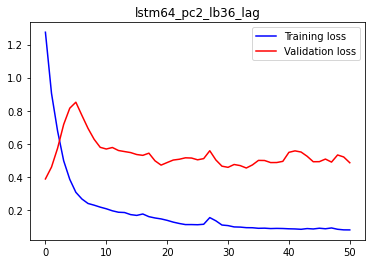

In [ ]:
plot_train_history(lstm_hist, lstm_name)

## Stack LSTM

In [ ]:
stack_lstm_units = [128,64]
stack_lstm_name = create_model_name('stack_lstm', stack_lstm_units)
stack_lstm_model = create_lstm_model(n_steps_in, n_features, n_steps_out, stack_lstm_name, units=stack_lstm_units)
stack_lstm_model.summary()

Model: "stack_lstm128_64_pc2_lb36_lag"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 36, 128)           67584     
                                                                 
 dropout_1 (Dropout)         (None, 36, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
Total params: 120,112
Trainable params: 120,112
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stack_lstm_hist = stack_lstm_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=500, callbacks = create_callbacks(stack_lstm_name), batch_size=32, verbose=1, shuffle=False)

Epoch 1/500
10/10 [==============================] - 4s 98ms/step - loss: 1.0317 - mae: 0.9052 - val_loss: 0.3191 - val_mae: 0.4814
Epoch 2/500
10/10 [==============================] - 0s 13ms/step - loss: 0.6444 - mae: 0.6655 - val_loss: 0.6219 - val_mae: 0.7070
Epoch 3/500
10/10 [==============================] - 0s 11ms/step - loss: 0.4336 - mae: 0.5336 - val_loss: 0.8008 - val_mae: 0.8406
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 0.3153 - mae: 0.4481 - val_loss: 0.8127 - val_mae: 0.8454
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.2580 - mae: 0.3953 - val_loss: 0.5791 - val_mae: 0.6843
Epoch 6/500
10/10 [==============================] - 0s 13ms/step - loss: 0.2270 - mae: 0.3730 - val_loss: 0.4603 - val_mae: 0.6034
Epoch 7/500
10/10 [==============================] - 0s 11ms/step - loss: 0.1993 - mae: 0.3474 - val_loss: 0.5621 - val_mae: 0.6958
Epoch 8/500
10/10 [==============================] - 0s 11ms/step - loss: 0.

In [ ]:
y_pred_stack_lstm_std = stack_lstm_model.predict(X_test)
y_pred_stack_lstm = scalerY.inverse_transform(y_pred_stack_lstm_std)
y_pred_stack_lstm

1/1 [==============================] - 1s 820ms/step


array([[34742.87 , 47887.93 , 51554.12 , 41878.293, 45522.473, 57119.688,
        47416.805, 45555.934, 35659.67 , 37726.844, 45457.93 , 37417.47 ,
        44734.12 , 42046.508, 46557.164, 39296.617, 47144.047, 48564.85 ,
        40180.457, 48402.94 , 45744.8  , 36790.508, 43515.938, 41754.34 ,
        56137.695, 49245.44 , 47509.188, 40891.902, 37342.39 , 45610.66 ,
        42845.457, 41348.293, 39842.77 , 35648.21 , 31168.742, 38766.223,
        45696.2  , 37051.52 , 42233.566, 39798.1  , 37159.07 , 53127.438,
        41589.215, 45338.633, 47186.89 , 33709.07 , 40229.785, 27692.244]],
      dtype=float32)

In [ ]:
print_errors(actualY, y_pred_stack_lstm[0], stack_lstm_name)

stack_lstm128_64_pc2_lb36_lag RMSE:  11126.54911428278
stack_lstm128_64_pc2_lb36_lag MAE:  9045.100870768229
stack_lstm128_64_pc2_lb36_lag MAPE:  20.391722934840605


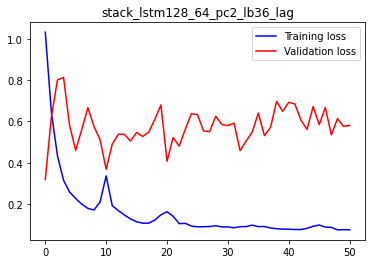

In [ ]:
plot_train_history(stack_lstm_hist, stack_lstm_name)

## Bidirectional LSTM

In [ ]:
bidirectional_units = [64]
merge_mode = 'ave'
bidirectional_lstm_name = create_model_name('bidirectional_lstm', bidirectional_units)
if merge_mode != 'concat':
  bidirectional_lstm_name += '_' + merge_mode
bidirectional_lstm_model = create_bidirectional_lstm_model(n_steps_in, n_features, n_steps_out, bidirectional_lstm_name, units=bidirectional_units, merge_mode=merge_mode)
bidirectional_lstm_model.summary()

Model: "bidirectional_lstm64_pc2_lb48_ave"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 64)               34304     
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 48)                3120      
                                                                 
Total params: 37,424
Trainable params: 37,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bidirectional_lstm_hist = bidirectional_lstm_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=500, callbacks = create_callbacks(bidirectional_lstm_name), batch_size=32, verbose=1, shuffle=False)

Epoch 1/500
9/9 [==============================] - 4s 106ms/step - loss: 1.1936 - mae: 0.9719 - val_loss: 0.2674 - val_mae: 0.4236
Epoch 2/500
9/9 [==============================] - 0s 12ms/step - loss: 0.9254 - mae: 0.8370 - val_loss: 0.3208 - val_mae: 0.4715
Epoch 3/500
9/9 [==============================] - 0s 12ms/step - loss: 0.7076 - mae: 0.7084 - val_loss: 0.3968 - val_mae: 0.5418
Epoch 4/500
9/9 [==============================] - 0s 12ms/step - loss: 0.5313 - mae: 0.5926 - val_loss: 0.4895 - val_mae: 0.6208
Epoch 5/500
9/9 [==============================] - 0s 11ms/step - loss: 0.3839 - mae: 0.4894 - val_loss: 0.5852 - val_mae: 0.6953
Epoch 6/500
9/9 [==============================] - 0s 12ms/step - loss: 0.2782 - mae: 0.4134 - val_loss: 0.6541 - val_mae: 0.7446
Epoch 7/500
9/9 [==============================] - 0s 11ms/step - loss: 0.2188 - mae: 0.3669 - val_loss: 0.6760 - val_mae: 0.7617
Epoch 8/500
9/9 [==============================] - 0s 11ms/step - loss: 0.1874 - mae: 0.3

In [ ]:
y_pred_bidirectional_lstm_std = bidirectional_lstm_model.predict(X_test)
y_pred_bidirectional_lstm = scalerY.inverse_transform(y_pred_bidirectional_lstm_std)
y_pred_bidirectional_lstm

1/1 [==============================] - 1s 634ms/step


array([[41449.65 , 37032.848, 28257.059, 39553.562, 28395.566, 38031.902,
        36243.18 , 43119.39 , 42402.12 , 48207.246, 41904.45 , 35974.035,
        34060.516, 36175.918, 38911.652, 41860.152, 41911.812, 34869.76 ,
        39367.223, 43790.305, 39707.77 , 43165.375, 46136.562, 42340.95 ,
        49498.754, 50557.344, 29217.908, 36951.633, 43410.62 , 40151.754,
        32330.418, 37139.49 , 31355.56 , 44822.84 , 41945.645, 42996.785,
        42705.03 , 33400.145, 45789.254, 37478.016, 45638.492, 42589.63 ,
        42121.86 , 50772.453, 39768.7  , 43026.36 , 26497.54 , 41826.074]],
      dtype=float32)

In [ ]:
print_errors(actualY, y_pred_bidirectional_lstm[0], bidirectional_lstm_name)

bidirectional_lstm64_pc2_lb48_ave RMSE:  9062.122800385569
bidirectional_lstm64_pc2_lb48_ave MAE:  7134.011555989583
bidirectional_lstm64_pc2_lb48_ave MAPE:  18.899281673368712


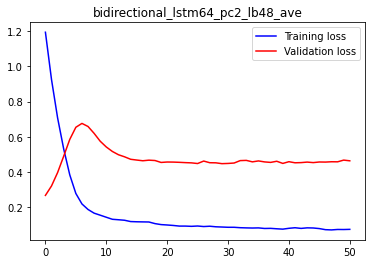

In [ ]:
plot_train_history(bidirectional_lstm_hist, bidirectional_lstm_name)

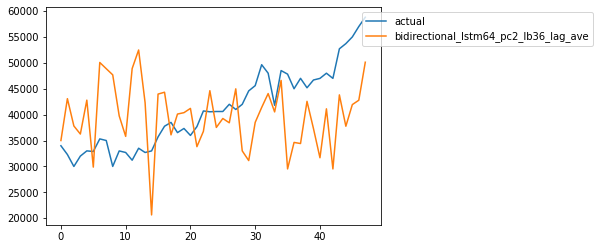

In [ ]:
plt.figsize=(20,10)
plt.plot(actualY, label='actual')
# plt.plot(y_pred_lstm[0], label=lstm_name)
# plt.plot(y_pred_stack_lstm[0], label=stack_lstm_name)
plt.plot(y_pred_bidirectional_lstm[0], label=bidirectional_lstm_name)
plt.legend(bbox_to_anchor=(1.65, 1), loc="upper right")
plt.show()

## Best Model Summary

*Need to run cells 1,2,3,4,5,7,12 before running this section

In [ ]:
best_lstm_model = 'lstm256_pc1_lb48_lag'
best_stack_lstm_model = 'stack_lstm128_64_32_pc2_lb48'
best_bidirectional_model = 'bidirectional_lstm128_pc2_lb36_lag_ave'

In [ ]:
def best_model_load_predict(n_steps_in, n_steps_out, npc, model_name, include_lag_feature=False):
  trainX, trainY, valX, valY, testX, testY, actualY = prepare_train_val_test(df, n_steps_in, n_steps_out, 'A')

  scalerX = StandardScaler().fit(trainX)
  X_train_std = scalerX.transform(trainX)
  X_val_std = scalerX.transform(valX)
  X_test_std = scalerX.transform(testX)

  scalerY = StandardScaler().fit(trainY)
  y_train_std = scalerY.transform(trainY)
  y_val_std = scalerY.transform(valY)
  y_test_std = scalerY.transform(testY)

  pca = PCA(n_components=npc, random_state=42)
  pca.fit(X_train_std)
  X_train_pca = pca.transform(X_train_std)
  X_val_pca = pca.transform(X_val_std)
  X_test_pca = pca.transform(X_test_std)

  if include_lag_feature:
    train_dataset = np.concatenate((X_train_pca, y_train_std, y_train_std), axis=1)
    val_dataset = np.concatenate((X_val_pca, y_val_std, y_val_std), axis=1)
    test_dataset = np.concatenate((X_test_pca, y_test_std, y_test_std), axis=1)
  else:
    train_dataset = np.concatenate((X_train_pca, y_train_std), axis=1)
    val_dataset = np.concatenate((X_val_pca, y_val_std), axis=1)
    test_dataset = np.concatenate((X_test_pca, y_test_std), axis=1)

  X_train, y_train = split_sequences(train_dataset, n_steps_in, n_steps_out)
  X_val, y_val = split_sequences(val_dataset, n_steps_in, n_steps_out)
  X_test, y_test = split_sequences(test_dataset, n_steps_in, n_steps_out)

  print("X train shape: {}, y train shape: {}".format(X_train.shape, y_train.shape))
  print("X validation shape: {}, y validation shape: {}".format(X_val.shape, y_val.shape))
  print("X test shape: {}, y test shape: {}".format(X_test.shape, y_test.shape))

  model_path = base_path + '/colab/' + model_name + '.hdf5'
  model = load_model(model_path)

  y_pred_std = model.predict(X_test)
  y_pred = scalerY.inverse_transform(y_pred_std)

  return y_pred[0]


In [ ]:
y_pred_best_lstm = best_model_load_predict(48, 48, 1, best_lstm_model, True)

X train shape: (277, 48, 2), y train shape: (277, 48)
X validation shape: (1, 48, 2), y validation shape: (1, 48)
X test shape: (1, 48, 2), y test shape: (1, 48)
1/1 [==============================] - 0s 341ms/step


In [ ]:
y_pred_best_stack_lstm = best_model_load_predict(48, 48, 2, best_stack_lstm_model, False)

X train shape: (277, 48, 2), y train shape: (277, 48)
X validation shape: (1, 48, 2), y validation shape: (1, 48)
X test shape: (1, 48, 2), y test shape: (1, 48)
1/1 [==============================] - 1s 947ms/step


In [ ]:
y_pred_best_bidirectional_lstm = best_model_load_predict(36, 48, 2, best_bidirectional_model, True)

X train shape: (289, 36, 3), y train shape: (289, 48)
X validation shape: (1, 36, 3), y validation shape: (1, 48)
X test shape: (1, 36, 3), y test shape: (1, 48)
1/1 [==============================] - 1s 1s/step


In [ ]:
def generate_x_labels(date_list):
  month_dict = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
  x_labels = []

  for d in date_list:
    yr, mth, day = d.split('-')
    if int(day) <= 14:
      bidding_exercise = '1'
    else:
      bidding_exercise = '2'
    x_labels.append("{} {} ({})".format(month_dict[int(mth)], yr, bidding_exercise))
  return x_labels

In [ ]:
x_labels = generate_x_labels(df.index.values)

In [ ]:
df_plot = pd.DataFrame(list(zip(x_labels[-48:], df['Quota Premium A'].values[-48:], y_pred_best_lstm, y_pred_best_stack_lstm, y_pred_best_bidirectional_lstm)),
               columns =['bidding exercise', 'actual', 'lstm', 'stack_lstm','bilstm'])
df_plot.set_index('bidding exercise', inplace=True)

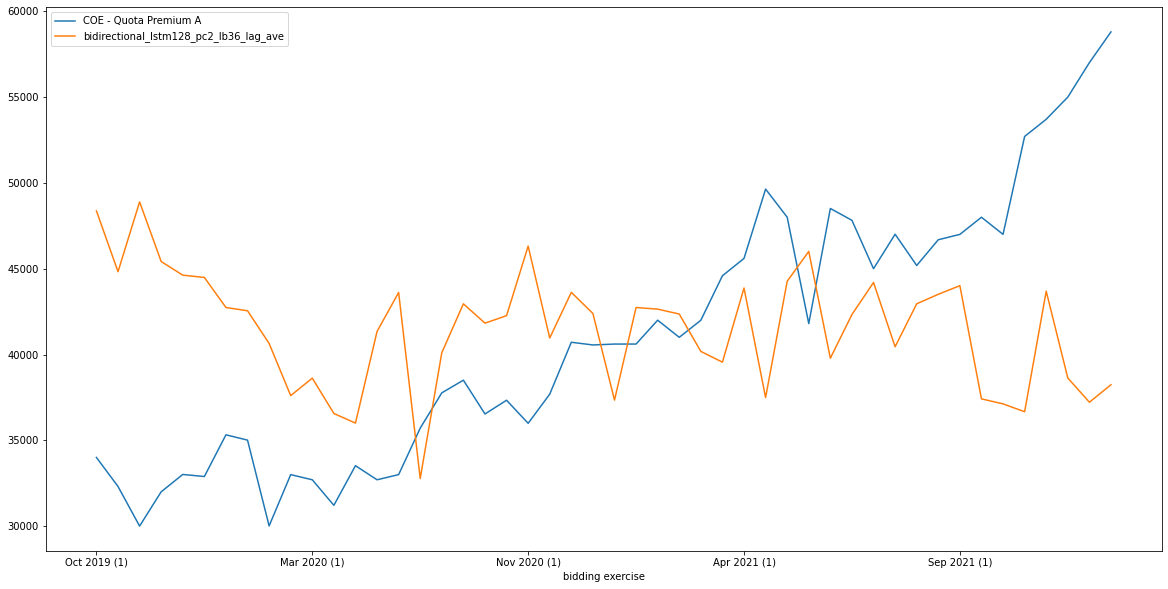

In [ ]:
plt.gcf().set_size_inches(20,10)
# x_labels = pd.to_datetime(df.index)
df_plot['actual'].plot(label='COE - Quota Premium A')
# df_plot['lstm'].plot(label=best_lstm_model)
# df_plot['stack_lstm'].plot(label=best_stack_lstm_model)
df_plot['bilstm'].plot(label=best_bidirectional_model)
plt.legend()
plt.show()